# Ungraded Lab: Implement a Siamese network

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw
import random


2025-01-21 15:48:25.676865: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-21 15:48:25.687482: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737474505.700070  375651 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737474505.703456  375651 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-21 15:48:25.718155: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## Prepare the Dataset

First define a few utilities for preparing and visualizing your dataset.

In [2]:
def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(10)]) - 1
    
    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
            
    return np.array(pairs), np.array(labels)


def create_pairs_on_set(images, labels):
    
    digit_indices = [np.where(labels == i)[0] for i in range(10)]
    pairs, y = create_pairs(images, digit_indices)
    y = y.astype('float32')
    
    return pairs, y


def show_image(image):
    plt.figure()
    plt.imshow(image)
    plt.colorbar()
    plt.grid(False)
    plt.show()

In [3]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [4]:
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

train_images /= 255.0
test_images /= 255.0

In [5]:
tr_pairs, tr_y = create_pairs_on_set(train_images, train_labels)
ts_pairs, ts_y = create_pairs_on_set(test_images, test_labels)

In [6]:
this_pair = 8

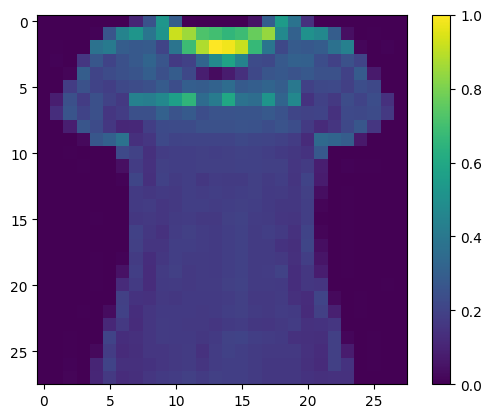

In [7]:
show_image(ts_pairs[this_pair][0])

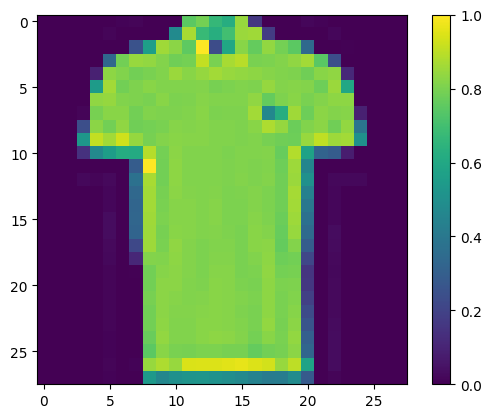

In [8]:
show_image(ts_pairs[this_pair][1])

In [9]:
print(ts_y[this_pair])

1.0


## Build the Model

Next, you'll define some utilities for building our model.

In [12]:
def initialize_base_network() -> tf.keras.Model:
    input = tf.keras.layers.Input(
        shape=(28, 28,),
        name="base_input"
    )
    x = tf.keras.layers.Flatten(name="flatten_input")(input)
    x = tf.keras.layers.Dense(128, activation='relu', name="first_base_dense")(x)
    x = tf.keras.layers.Dropout(0.1, name="first_dropout")(x)
    x = tf.keras.layers.Dense(128, activation='relu', name="second_base_dense")(x)
    x = tf.keras.layers.Dropout(0.1, name="second_dropout")(x)
    x = tf.keras.layers.Dense(128, activation='relu', name="third_base_dense")(x)
    return Model(
        inputs=input,
        outputs=x
    )


def euclidian_distance(vectors):
    x, y = vectors
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, _ = shapes
    return (shape1[0], 1)

I0000 00:00:1737474511.086055  375651 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5566 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


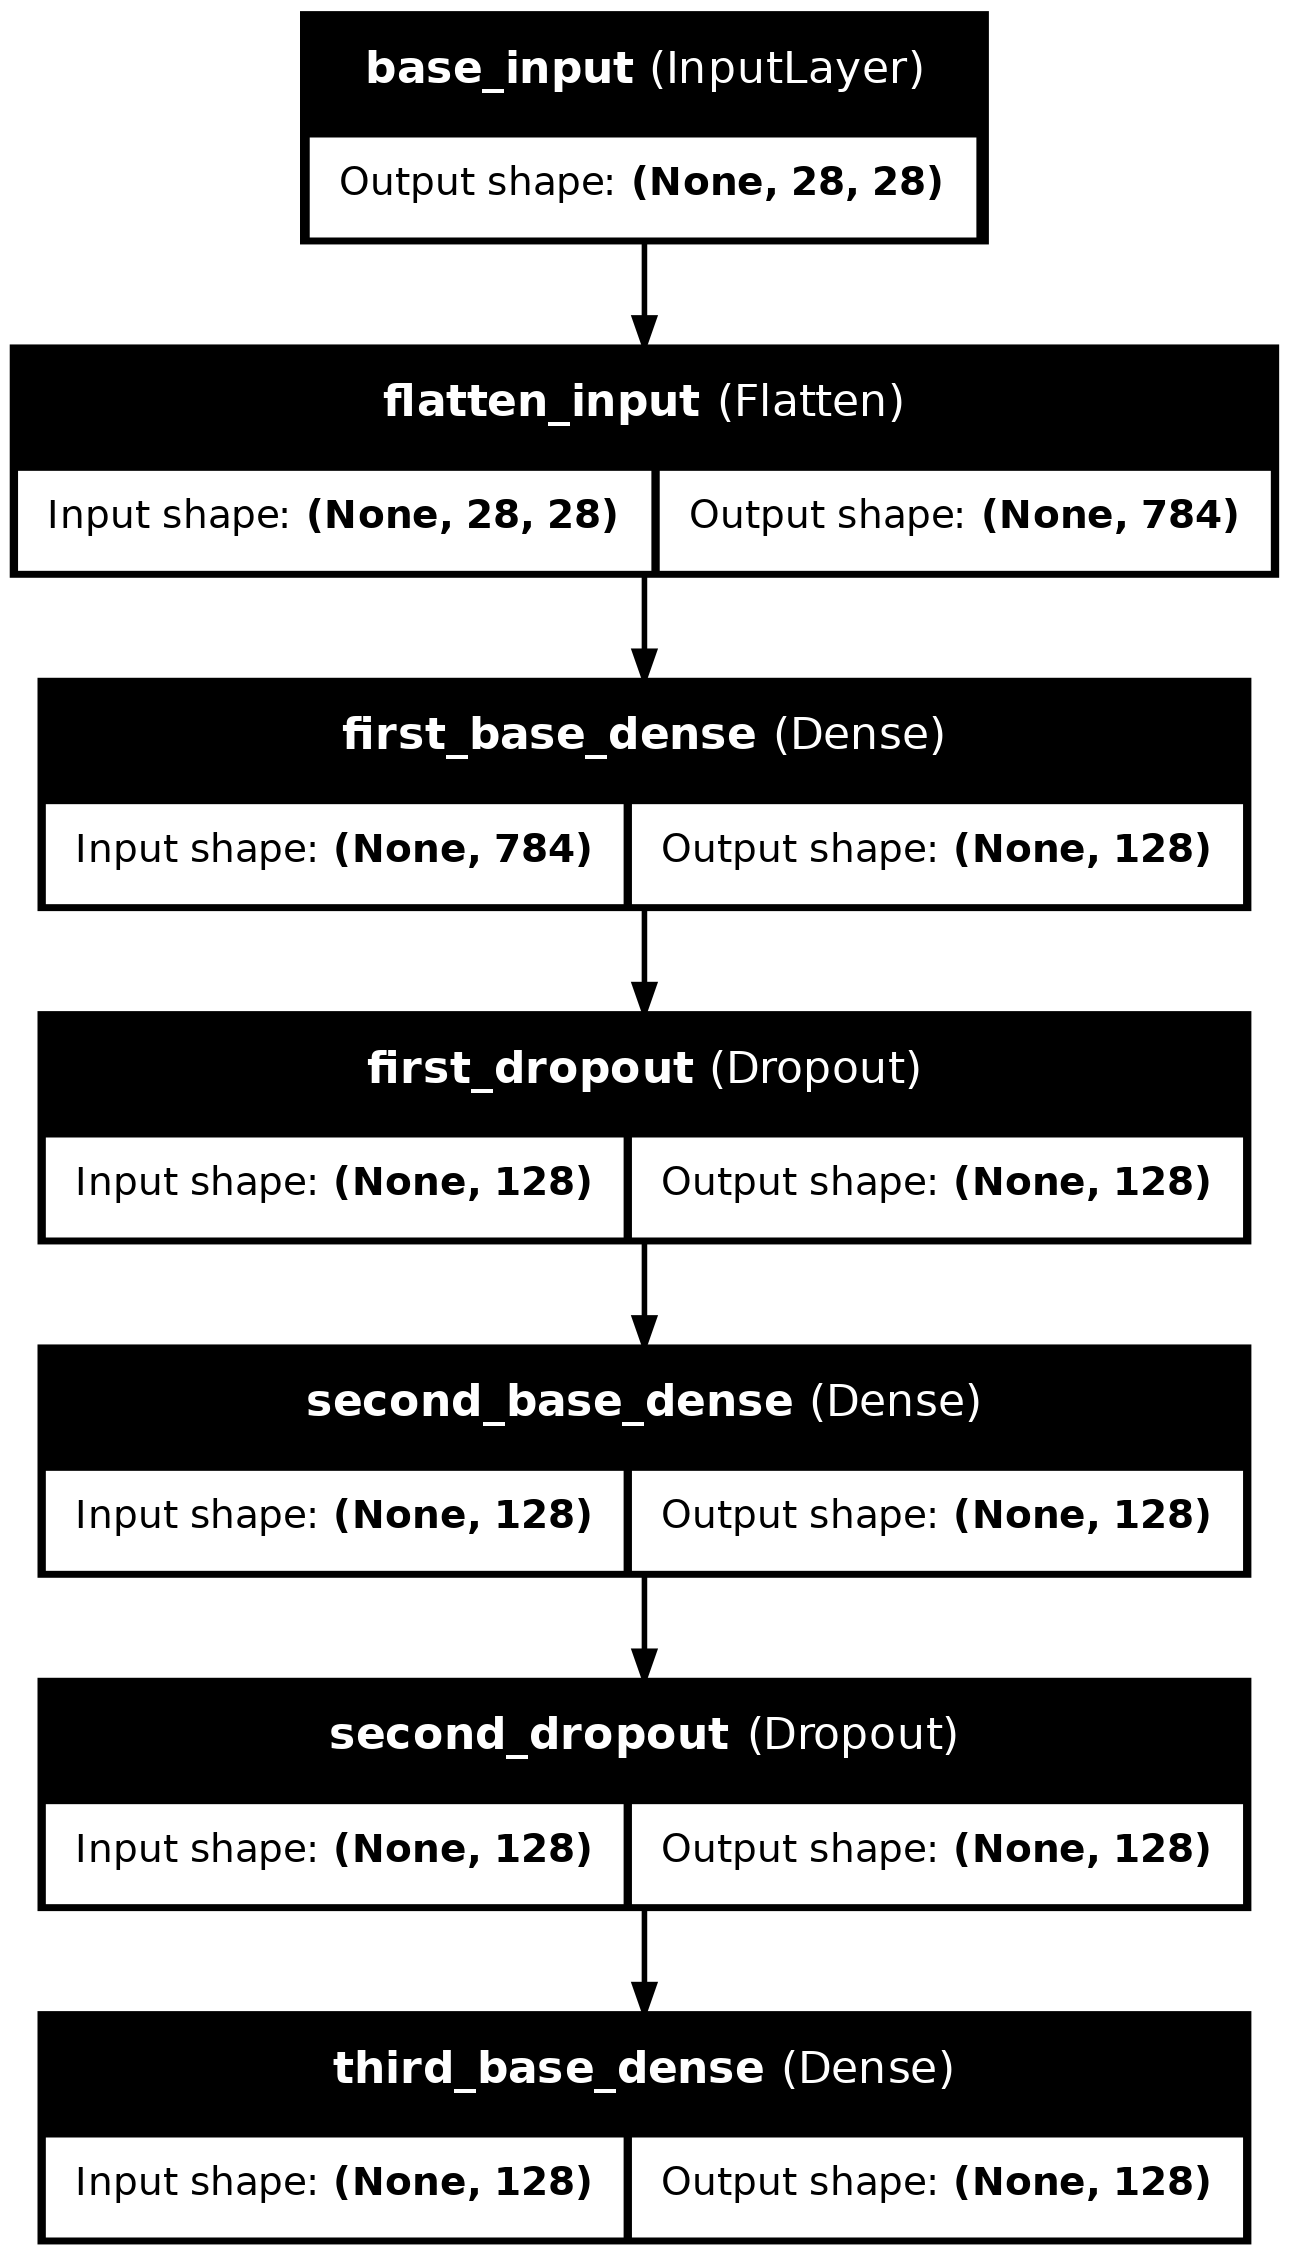

In [11]:
base_network = initialize_base_network()
plot_model(base_network, show_shapes=True, show_layer_names=True, to_file="base-model.png")

Let's now build the Siamese network. The plot will show two inputs going to the base network.

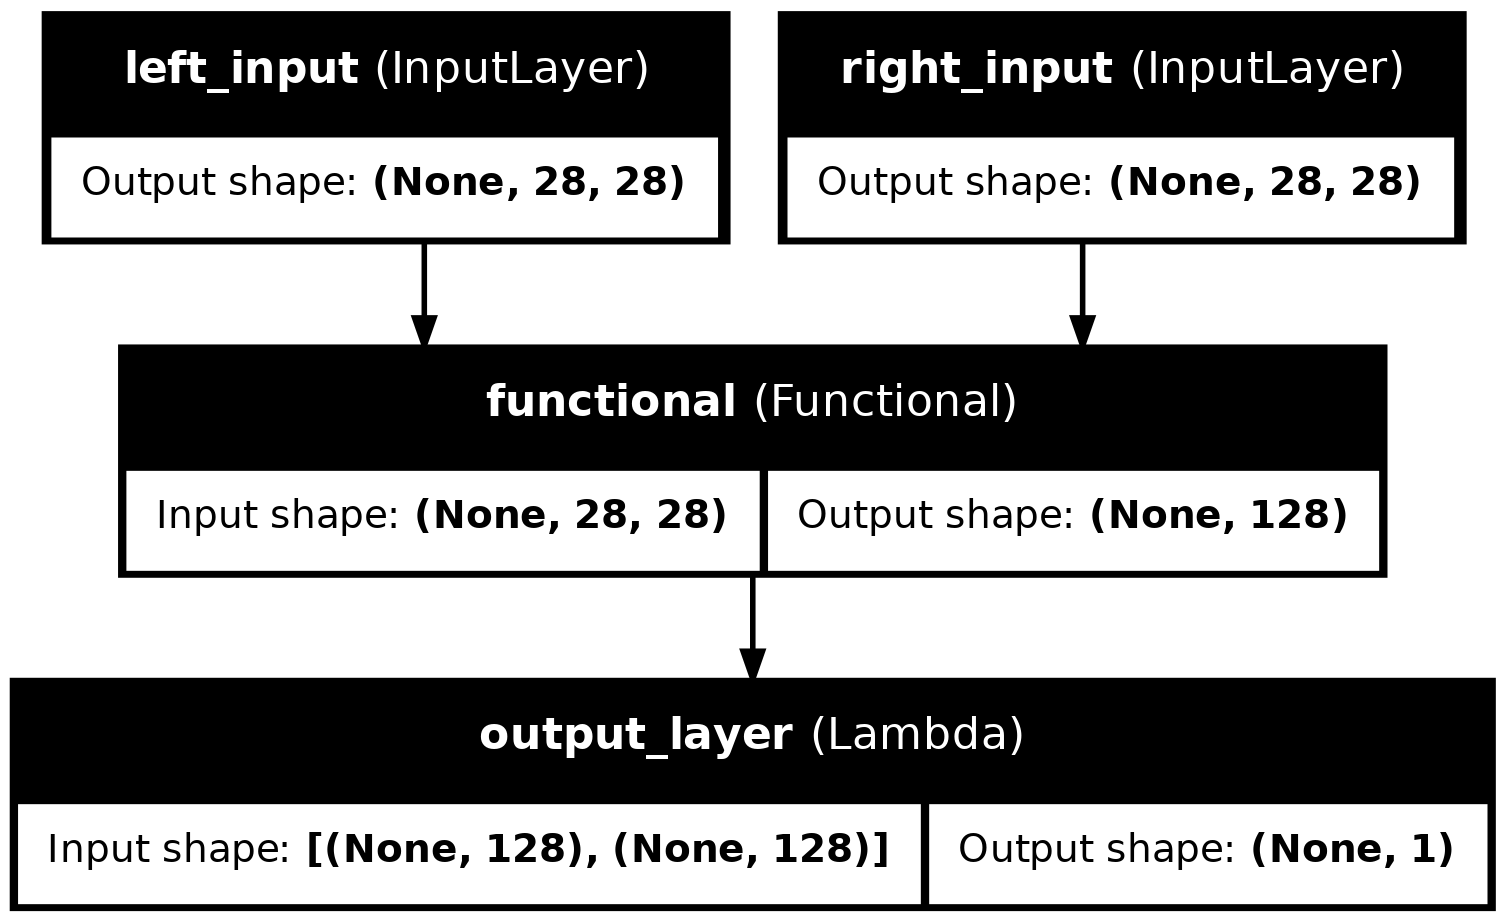

In [23]:
input_a = tf.keras.layers.Input(
    shape=(28, 28,),
    name="left_input"
)
vect_output_a = base_network(
    input_a
)

input_b = tf.keras.layers.Input(
    shape=(28, 28,),
    name="right_input"
)
vect_output_b = base_network(
    input_b
)

output = tf.keras.layers.Lambda(
    euclidian_distance,
    name="output_layer",
    output_shape=eucl_dist_output_shape
)([vect_output_a, vect_output_b])

model = Model(
    [input_a, input_b],
    output
)

plot_model(model, show_shapes=True, show_layer_names=True, to_file='outer-model.png')

## Train the Model

You can now define the custom loss for our network and start training.

In [31]:
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return (y_true * square_pred + (1 - y_true) * margin_square)
    return contrastive_loss

In [ ]:
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        '''Contrastive loss from Hadsell-et-al.'06
        http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
        '''
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return (y_true * square_pred + (1 - y_true) * margin_square)
    return contrastive_loss

In [32]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3
)

In [33]:
rms = RMSprop()
model.compile(
    loss=contrastive_loss_with_margin(margin=1),
    optimizer=rms
)

In [34]:
history = model.fit([tr_pairs[:,0], tr_pairs[:,1]], tr_y, callbacks=[early_stopping], epochs=20, batch_size=128, validation_data=([ts_pairs[:,0], ts_pairs[:,1]], ts_y))

Epoch 1/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.1270 - val_loss: 0.0711
Epoch 2/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0673 - val_loss: 0.0729
Epoch 3/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0624 - val_loss: 0.0690
Epoch 4/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0601 - val_loss: 0.0697
Epoch 5/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0584 - val_loss: 0.0700
Epoch 6/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0568 - val_loss: 0.0714


## Model Evaluation

As usual, you can evaluate our model by computing the accuracy and observing the metrics during training.

In [17]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)

In [18]:
loss = model.evaluate(x=[ts_pairs[:,0],ts_pairs[:,1]], y=ts_y)

y_pred_train = model.predict([tr_pairs[:,0], tr_pairs[:,1]])
train_accuracy = compute_accuracy(tr_y, y_pred_train)

y_pred_test = model.predict([ts_pairs[:,0], ts_pairs[:,1]])
test_accuracy = compute_accuracy(ts_y, y_pred_test)

print(f"Loss = {loss}, Train Accuracy = {train_accuracy} Test Accuracy = {test_accuracy}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5000
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Loss = 0.5000000596046448, Train Accuracy = 0.5 Test Accuracy = 0.5


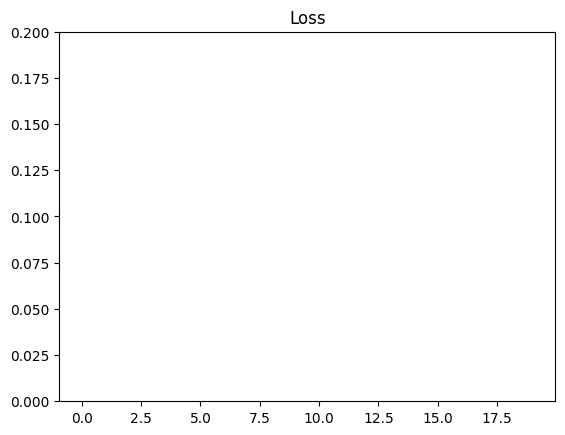

In [22]:
def plot_metrics(metric_name, history, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)


plot_metrics(metric_name='loss', history=history, title="Loss", ylim=0.2)

In [20]:
# Matplotlib config
def visualize_images():
    plt.rc('image', cmap='gray_r')
    plt.rc('grid', linewidth=0)
    plt.rc('xtick', top=False, bottom=False, labelsize='large')
    plt.rc('ytick', left=False, right=False, labelsize='large')
    plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
    plt.rc('text', color='a8151a')
    plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts


# utility to display a row of digits with their predictions
def display_images(left, right, predictions, labels, title, n):
    plt.figure(figsize=(17,3))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
    plt.grid(None)
    left = np.reshape(left, [n, 28, 28])
    left = np.swapaxes(left, 0, 1)
    left = np.reshape(left, [28, 28*n])
    plt.imshow(left)
    plt.figure(figsize=(17,3))
    plt.yticks([])
    plt.xticks([28*x+14 for x in range(n)], predictions)
    for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if predictions[i] > 0.5: t.set_color('red') # bad predictions in red
    plt.grid(None)
    right = np.reshape(right, [n, 28, 28])
    right = np.swapaxes(right, 0, 1)
    right = np.reshape(right, [28, 28*n])
    plt.imshow(right)



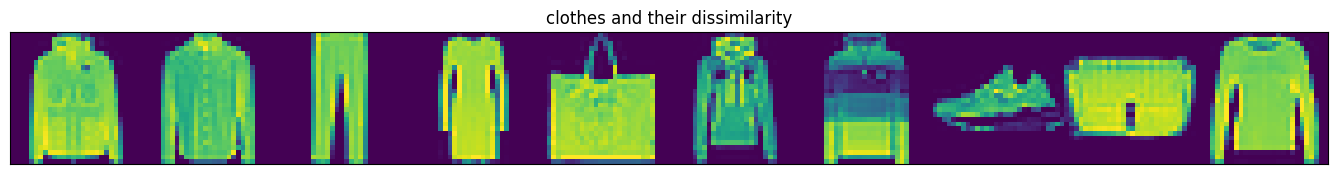

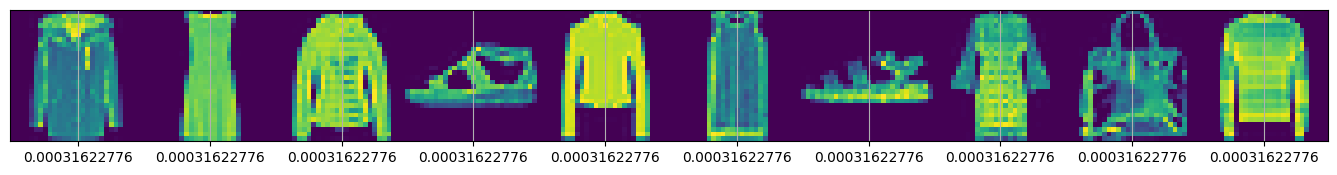

In [21]:
y_pred_train = np.squeeze(y_pred_train)
indexes = np.random.choice(len(y_pred_train), size=10)
display_images(tr_pairs[:, 0][indexes], tr_pairs[:, 1][indexes], y_pred_train[indexes], tr_y[indexes], "clothes and their dissimilarity", 10)